## Feature Selection with Pandas

Feature selection is one of the first and important steps while performing any machine learning task. A feature in case of a dataset simply means a column. When we get any dataset, not necessarily every column (feature) is going to have an impact on the output variable. If we add these irrelevant features in the model, it will just make the model worst (Garbage In Garbage Out). This gives rise to the need of doing feature selection.

When it comes to implementation of feature selection in Pandas, Numerical and Categorical features are to be treated differently. Here we will first discuss about Numeric feature selection. Hence before implementing the following methods, we need to make sure that the DataFrame only contains Numeric features. Also, the following methods are discussed for regression problem, which means both the input and output variables are continuous in nature.

Feature selection can be done in multiple ways but there are broadly 3 categories of it:
1. Filter Method 
2. Wrapper Method 
3. Embedded Method

### About the dataset:
We will be using the built-in Boston dataset which can be loaded through sklearn. We will be selecting features using the above listed methods for the regression problem of predicting the "MEDV" column. In the following 2 cells we will import all the required libraries and load the dataset.

In [1]:
#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

C:\Users\Abhini25\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Loading the dataset
x = load_boston()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target
X = df.drop("MEDV",1)   #Feature Matrix
y = df["MEDV"]          #Target Variable
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 1.	Filter Method:
As the name suggest, you filter and take only the subset of the relevant features. The model is built after selecting the features. The filtering here is done using correlation matrix and it is most commonly done using Pearson correlation.

Here we will first plot the pearson correlation heatmap and see the correlation of independent variables with the output variable MEDV. We will only select features which has correlation of above 0.5 (taking absolute value) with the output variable.

The correlation coefficient has values between -1 to 1
    - A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
    - A value closer to 1 implies stronger positive correlation
    - A value closer to -1 implies stronger negative correlation

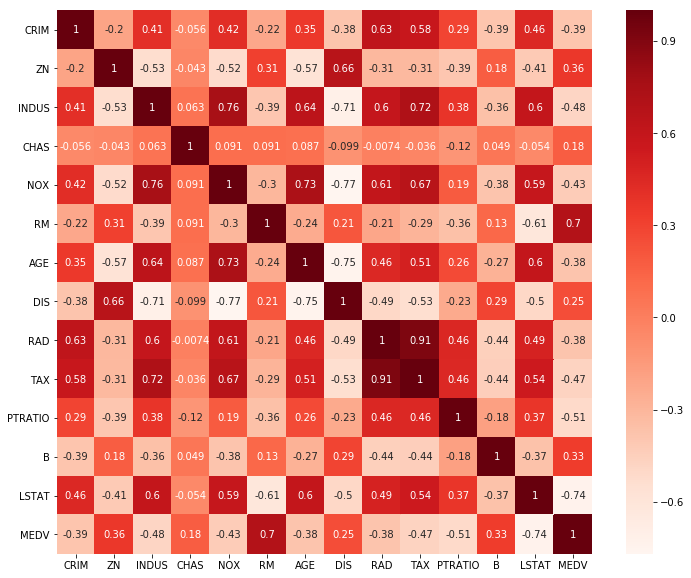

In [3]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [4]:
cor_target = abs(cor["MEDV"])   #Correlation with output variable
relevant_features = cor_target[cor_target>0.5]   #Selecting highly correlated features
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

As we can see, only the features RM, PTRATIO and LSTAT are highly correlated with the output variable MEDV. Hence we will drop all other features apart from these. However this is not the end of the process. One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest. So let us check the correlation of selected features with each other.

In [5]:
print(df[["LSTAT","PTRATIO"]].corr())
print(df[["RM","LSTAT"]].corr())

            LSTAT   PTRATIO
LSTAT    1.000000  0.374044
PTRATIO  0.374044  1.000000
             RM     LSTAT
RM     1.000000 -0.613808
LSTAT -0.613808  1.000000


From the above code, it is seen that the variables RM and LSTAT are highly correlated with each other (-0.613808). Hence we would keep only one variable and drop the other. We will keep LSTAT since its correlation with MEDV is higher than that of RM.

After dropping RM, we are left with two feature, **LSTAT** and **PTRATIO**. These are the final features given by Pearson correlation.

### 2.	Wrapper Method:
A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

There are different wrappers method such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE. We will discuss Backward Elimination and RFE here.

#### i. Backward Elimination

As the name suggest, we feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

We will first run one iteration here just to get an idea of the concept and then we will run the same code in a loop, which will give the final set of features. Here we are using OLS model which stands for "Ordinary Least Square". This model is used for performing linear regression.

In [6]:
X_1 = sm.add_constant(X)   #Adding constant column of ones, mandetory for sm.OLS model
model = sm.OLS(y,X_1).fit()   #Fitting sm.OLS model
model.pvalues

const      3.283438e-12
CRIM       1.086810e-03
ZN         7.781097e-04
INDUS      7.382881e-01
CHAS       1.925030e-03
NOX        4.245644e-06
RM         1.979441e-18
AGE        9.582293e-01
DIS        6.013491e-13
RAD        5.070529e-06
TAX        1.111637e-03
PTRATIO    1.308835e-12
B          5.728592e-04
LSTAT      7.776912e-23
dtype: float64

As we can see that the variable 'AGE' has highest pvalue of 0.9582293 which is greater than 0.05. Hence we will remove this feature and build the model once again. This is an iterative process and can be performed at once with the help of loop. This approach is implemented below, which would give the final set of variables which are **CRIM**, **ZN**, **CHAS**, **NOX**, **RM**, **DIS**, **RAD**, **TAX**, **PTRATIO**, **B** and **LSTAT**

In [7]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


#### ii. RFE (Recursive Feature Elimination)

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [8]:
model = LinearRegression()
rfe = RFE(model, 7)             #Initializing RFE model
X_rfe = rfe.fit_transform(X,y)  #Transforming data using RFE
model.fit(X_rfe,y)              #Fitting the data to model
print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


Here we took LinearRegression model with 7 features and RFE gave feature ranking as above, but the selection of number '7' was random. Now we need to find the optimum number of features, for which the accuracy is the highest. We do that by usig loop starting with 1 feature and going upto 13. We then take the one for which the accuracy is highest.

In [9]:
nof_list=np.arange(1,13)            #no of features
high_score=0
nof=0           #Variable to store the optimum features
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 10
Score with 10 features: 0.663581


As seen from above code, the optimum number of features is 10. We now feed 10 as number of features to RFE and get the final set of features given by RFE method, as follows:

In [10]:
cols = list(X.columns)
model = LinearRegression()
rfe = RFE(model, 10)             #Initializing RFE model
X_rfe = rfe.fit_transform(X,y)  #Transforming data using RFE
model.fit(X_rfe,y)              #Fitting the data to model
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


### 3. Embedded Method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it's coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [11]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444


C:\Users\Abhini25\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [12]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 3 variables


Text(0.5,1,'Feature importance using Lasso Model')

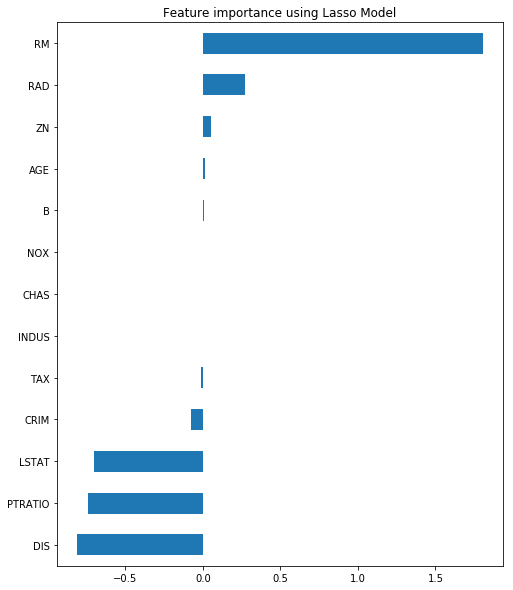

In [13]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Here Lasso model has taken all the features except NOX, CHAS and INDUS.

### Conclusion:

We saw how to select features using multiple methods for Numeric Data and compared their results. Now there arises a confusion of which method to choose in what situation. Following points will help you make this decision.
1. Filter method is less accurate. It is great while doing EDA, it can also be used for checking multi-collinearity in data.
2. Wrapper and Embedded methods give more accurate results but as they are computationally expensive, these method are suited when you have lesser features (~20).